# Train model to autonomously drive your 8-bit car

In [38]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import joblib

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Utilities

In [39]:
# 0 = Left, 1 = Straight, 2 = Right
direction = ['Left', 'Straight', 'Right']

def show_road(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((10,25))
    print(imgr)
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)


## Load the driving training data

In [40]:
df = pd.read_csv('training.csv', header=None)
X = df.loc[:, 1:]
y = df.loc[:, 0]


In [41]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,1,2,2,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,1,2,2,2,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,1,2,2,2,...,0,0,0,0,0,0,0,0,0,0


[[0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0]]


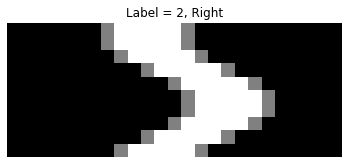

In [42]:
road_matrix = df.values
row = 123
show_road(road_matrix[row][1:], "Label = {}, {}".format(road_matrix[row][0], direction[road_matrix[row][0]]))

## Create map of models to train

In [43]:
models = [
        {
            'model': LogisticRegression(multi_class='multinomial'),
            'params_grid': dict(penalty=['l2'], C=[10, 1, 0.1, 0.01], solver=['newton-cg', 'sag', 'lbfgs'],
                                max_iter=[100, 200, 300]),
            'name': 'LogisticRegression',
            'skip': False
        },
        {
            'model': DecisionTreeClassifier(),
            'params_grid': dict(criterion=['gini', 'entropy'], max_depth=[2, 3, 4, 5], min_samples_split=[2, 3]),
            'name': 'DecisionTree',
            'skip': False
        },
        {
            'model': SVC(kernel='linear', C=1),
            'params_grid': dict(kernel=['linear', 'rbf', 'poly'], gamma=['auto', 'scale']),
            'name': 'SVC',
            
            'skip': False
        },
        {
            'model': GaussianNB(),
            'params_grid': None,
            'name': 'MultinomialNB',
            'skip': True
        },
        {
            'model': KNeighborsClassifier(),
            'params_grid': dict(n_neighbors=list(range(1, 10)), weights=['uniform', 'distance']),
            'name': 'KNN GridSearch',
            'skip': False
        },
        {
            'model': KNeighborsClassifier(),
            'params_grid': None,
            'name': 'KNN Default',
            'skip': True
        },
        {
            'model': LinearRegression(),
            'params_grid': None,
            'name': 'Linear',
            'skip': True
        },
        {
            'model': RandomForestClassifier(),
            'params_grid': dict(n_estimators=[100], max_depth=[2,3,4]),
            'name': 'RandomForestClassifier',
            'skip': False
        }

    ]


#### Train Model Utility Function

In [44]:
def train_model(model, X, y, name=None, param_grid=None):
    if name:
        print(f"\nTraining: {name}")

    if param_grid:
        grid = GridSearchCV(model, param_grid, cv=5)
        grid.fit(X, y)
        print(grid.best_score_)
        print(grid.best_params_)
        print(grid.best_estimator_)
        best_model = grid.best_estimator_
        best_params = grid.best_params_
        best_score = grid.best_score_
    else:
        cv_scores = cross_val_score(model, X, y, cv=5)
        print(cv_scores, cv_scores.mean())
        best_model = model
        best_params = param_grid
        best_score = cv_scores.mean()

    return best_score, best_params, best_model


## Find the best model to drive the car

In [45]:
best_model = None
best_params = None
best_score = -1
for model in models:
    if not model['skip']:
        score, params, best = train_model(model['model'], X, y, name=model['name'], param_grid=model['params_grid'])

        if score > best_score:
            best_params = params
            best_model = best
            best_score = score



Training: LogisticRegression
0.8
{'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
LogisticRegression(C=0.01, multi_class='multinomial', solver='newton-cg')

Training: DecisionTree
0.8266666666666668
{'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}
DecisionTreeClassifier(criterion='entropy', max_depth=3)

Training: SVC
0.8066666666666666
{'gamma': 'auto', 'kernel': 'linear'}
SVC(C=1, gamma='auto', kernel='linear')

Training: KNN GridSearch
0.8066666666666669
{'n_neighbors': 9, 'weights': 'uniform'}
KNeighborsClassifier(n_neighbors=9)

Training: RandomForestClassifier
0.8266666666666668
{'max_depth': 2, 'n_estimators': 100}
RandomForestClassifier(max_depth=2)


In [46]:
print(best_model)
print(best_params) 
print(best_score)

DecisionTreeClassifier(criterion='entropy', max_depth=3)
{'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}
0.8266666666666668


## Save the best model

In [47]:
joblib.dump(best_model, "best_driving_model.sav")


['best_driving_model.sav']